Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Give the base directory here
base_dir = "/content/drive/My Drive"

Mounted at /content/drive


Importing Libraries

In [ ]:
import pickle
import os
import torch
import torch.nn as nn
import numpy as np

from torch.utils.data import Dataset,DataLoader, random_split

Reading Data from file

In [ ]:
datapath = os.path.join(base_dir,'data_train.pkl')

with open(datapath, 'rb') as f: 
    data_train = pickle.load(f)

# print(data_train.keys()) 

# pts2d_1 = data_train['joint_2d_1']
# pts2d_2 = data_train['joint_2d_2']
# rot = data_train['rot']
# transl = data_train['transl']
# focal_len_1 = data_train['focal_len_1']
# focal_len_2 = data_train['focal_len_2']
# pts3d = data_train['joint_3d']


Dataset Class

In [ ]:
class data(Dataset):

    def __init__(self, base_dir):
  
        self.base_dir = base_dir
        datapath = os.path.join(base_dir,'data_train.pkl')

        with open(datapath, 'rb') as f: 
            data_train = pickle.load(f)

        self.length = len(data_train['joint_3d'])

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        
        pts2d_1 = data_train['joint_2d_1'][idx]
        pts2d_2 = data_train['joint_2d_2'][idx]
        rot = data_train['rot'][idx]
        transl = data_train['transl'][idx]
        focal_len_2 = data_train['focal_len_2'][idx]
        target = {"pts2d": pts2d_2,"rot": rot, "transl":transl,"focal_len_2":focal_len_2}

        return pts2d_1,target

Model

In [ ]:
class LiftModel(nn.Module):

  def __init__(self,n_blocks=2, hidden_layer=1024, dropout=0.1, output_nodes=15*3):
    super(LiftModel, self).__init__()
    self.n_blocks = n_blocks
    self.hidden_layer = hidden_layer
    self.dropout = dropout
    self.output_nodes = output_nodes
    self.input_nodes = 15*2

    self.linear0 = nn.Linear(self.input_nodes, 1024)

    self.blocks = nn.ModuleList()

    self.block = nn.Sequential( 
        nn.Linear(1024,1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(self.dropout),
        nn.Linear(1024,1024),
        nn.BatchNorm1d(1024),
        nn.ReLU(),
        nn.Dropout(self.dropout)
        )
    
    for i in range(self.n_blocks):
      self.blocks.append(self.block)
  
    self.output = nn.Linear(1024,self.output_nodes)

  def forward(self,x):
      x = x.view(-1,30)
      x = self.linear0(x)
      for i in range(self.n_blocks):
        x = self.blocks[i](x)

      x = self.output(x)
      x = x.view(-1,15,3)
      
      return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LiftModel()
model = model.to(device)

Loss Function

In [ ]:
def cal_mpjpe(pose_1, pose_2, avg=True):
    n_joints = pose_1.shape[1]
    batch_size = pose_1.shape[0]
    pose_1 = pose_1.clone().reshape(batch_size, n_joints, 2)
    pose_2 = pose_2.clone().reshape(batch_size, n_joints, 2)
    diff = pose_1-pose_2
    diff_sq = diff ** 2
    dist_per_joint = torch.sqrt(torch.sum(diff_sq, axis=2))
    dist_per_sample = torch.mean(dist_per_joint, axis=1)
    if avg is True:
        dist_avg = torch.mean(dist_per_sample)
    else:
        dist_avg = dist_per_sample
    return dist_avg

Training Section

In [ ]:
def train(model,train_loader,optimizer):
  epoch_loss = 0

  model.train()

  for input,target in train_loader:
    
    input = input.to(device)
    #target = target.to(device)

    predicted = model(input)

    pts2d_b = target["pts2d"]
    rot = target["rot"]
    transl = target["transl"]
    focal_len= target["focal_len_2"]
    
    pts2d_b = torch.from_numpy(np.asarray(pts2d_b))

    rot = torch.from_numpy(np.reshape(np.asarray(rot),(-1,3,3)))
    transl = torch.from_numpy(np.repeat(np.asarray(transl[:,:,np.newaxis]),15,axis=2) )
    focal_len_2 = torch.from_numpy(np.repeat(np.asarray(focal_len[:,:,np.newaxis]),15,axis=2))
    predicted = torch.transpose(predicted,2,1).cpu()

    estim = rot@predicted - transl
    estim1 = estim.clone()
    estim1[:,0,:] = (estim[:,0,:]*focal_len_2[:,0])/estim[:,2,:]
    estim1[:,1,:] = (estim[:,1,:]*focal_len_2[:,1])/estim[:,2,:]
    est_pts2d = estim1[:,0:2,:]
    est_pts2d = torch.transpose(est_pts2d,2,1)

    loss = cal_mpjpe((est_pts2d),(pts2d_b))
    

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    #scheduler.step()

    epoch_loss += loss.item()

  return epoch_loss / len(train_loader)

In [ ]:
def validation(model,valid_loader):
  epoch_loss = 0

  model.eval()

  with torch.no_grad():

    for input,target in valid_loader:

      input = input.to(device)
      predicted = model(input)

      pts2d_b = target["pts2d"]
      rot = target["rot"]
      transl = target["transl"]
      focal_len= target["focal_len_2"]
      
      pts2d_b = torch.from_numpy(np.asarray(pts2d_b))

      rot = torch.from_numpy(np.reshape(np.asarray(rot),(-1,3,3)))
      transl = torch.from_numpy(np.repeat(np.asarray(transl[:,:,np.newaxis]),15,axis=2) )
      focal_len_2 = torch.from_numpy(np.repeat(np.asarray(focal_len[:,:,np.newaxis]),15,axis=2))
      predicted = torch.transpose(predicted,2,1).cpu()

      estim = rot@predicted - transl
      estim1 = estim.clone()
      estim1[:,0,:] = (estim[:,0,:]*focal_len_2[:,0])/estim[:,2,:]
      estim1[:,1,:] = (estim[:,1,:]*focal_len_2[:,1])/estim[:,2,:]
      est_pts2d = estim1[:,0:2,:]
      est_pts2d = torch.transpose(est_pts2d,2,1)

      loss = cal_mpjpe((est_pts2d),(pts2d_b))

      epoch_loss += loss.item()
  
  return epoch_loss / len(valid_loader)

In [ ]:
def run_epoch(epoch_no, data, model, optimiser, scheduler, batch_size=64, split='train'):

  n_val = int(len(data) * 0.1)
  n_train = len(data) - n_val
  train_dataset, valid_dataset = random_split(data,[n_train, n_val])

  train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True, drop_last=True, pin_memory= True,num_workers=8)
  valid_loader = DataLoader(valid_dataset,batch_size=batch_size,shuffle=True, drop_last=True, pin_memory=True,num_workers=8)

  train_loss_history = []
  valid_loss_history = []

  for epoch in range(epoch_no):

    train_loss = train(model,train_loader,optimizer)
    valid_loss = validation(model,valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

  torch.save({'model_state_dict':model.state_dict()}, os.path.join(base_dir,'bestModel.pt'))

  return train_loss_history, valid_loss_history


In [ ]:
from torch import optim

learning_rate = 1e-3
T_max = 100
step_size = 50
num_epochs = 50
optimizer = optim.Adam(model.parameters(),lr = learning_rate)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=10e-6, last_epoch=-1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size, gamma=0.1, last_epoch=-1, verbose=False)

dataset = data(base_dir)

In [ ]:
train_loss, val_loss = run_epoch(num_epochs,dataset,model,optimizer,scheduler)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 01
	Train Loss: 0.317
	 Val. Loss: 0.229
Epoch: 02
	Train Loss: 0.270
	 Val. Loss: 0.229
Epoch: 03
	Train Loss: 0.172
	 Val. Loss: 0.229
Epoch: 04
	Train Loss: 0.167
	 Val. Loss: 0.234
Epoch: 05
	Train Loss: 0.165
	 Val. Loss: 0.231
Epoch: 06
	Train Loss: 0.163
	 Val. Loss: 0.236
Epoch: 07
	Train Loss: 0.162
	 Val. Loss: 0.238
Epoch: 08
	Train Loss: 0.161
	 Val. Loss: 0.248
Epoch: 09
	Train Loss: 0.159
	 Val. Loss: 0.256
Epoch: 10
	Train Loss: 0.158
	 Val. Loss: 0.251
Epoch: 11
	Train Loss: 0.156
	 Val. Loss: 0.241
Epoch: 12
	Train Loss: 0.154
	 Val. Loss: 0.245
Epoch: 13
	Train Loss: 0.151
	 Val. Loss: 0.251
Epoch: 14
	Train Loss: 0.147
	 Val. Loss: 0.248
Epoch: 15
	Train Loss: 0.143
	 Val. Loss: 0.249
Epoch: 16
	Train Loss: 0.138
	 Val. Loss: 0.240
Epoch: 17
	Train Loss: 0.133
	 Val. Loss: 0.239
Epoch: 18
	Train Loss: 0.127
	 Val. Loss: 0.238
Epoch: 19
	Train Loss: 0.120
	 Val. Loss: 0.229
Epoch: 20
	Train Loss: 0.112
	 Val. Loss: 0.214
Epoch: 21
	Train Loss: 0.104
	 Val. Loss

Training loss vs Validation Loss

Text(0.5, 0, 'epoch')

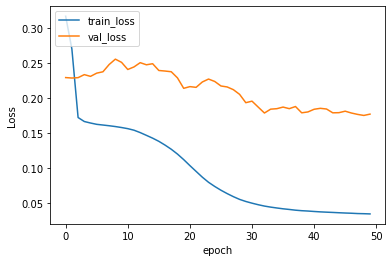

In [ ]:
#num_epochs = len(val_loss)
import matplotlib.pyplot as plt

x = range(0,num_epochs)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x,train_loss, label='train_loss')
ax.plot(x,val_loss, label='val_loss')
leg1 = ax.legend(loc='upper left')
ax.set_ylabel('Loss')
ax.set_xlabel('epoch')